In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy.signal import correlate2d
import scipy.spatial as sp
from scipy.stats import spearmanr
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%%capture
from google.colab import drive
drive.mount('/content/gdrive')
!jar xvf gdrive/MyDrive/Diploma/COVIDx8B_test.zip

In [ ]:
img_size = (224, 224)

test_images_paths = np.load('gdrive/MyDrive/Diploma/explanations/test_data_paths.npy')
test_images_labels = np.concatenate((np.full(shape=(100, ), fill_value=0), np.full(shape=(100, ), fill_value=1)))

def normalize_array(arr):
  return (arr - arr.min(axis=(1, 2))[:, None, None]) / (arr.max(axis=(1, 2))[:, None, None] - arr.min(axis=(1, 2))[:, None, None])

expl_dir = 'gdrive/MyDrive/Diploma/explanations/'

permutation_explanations = normalize_array(np.load(expl_dir + 'permutation_explanations.npy'))
lime_explanations = normalize_array(np.load(expl_dir + 'lime_explanations.npy'))
shap_explanations = normalize_array(np.load(expl_dir + 'shap_explanations.npy'))
ig_explanations = normalize_array(np.load(expl_dir + 'ig_explanations.npy'))
gradcam_explanations = normalize_array(np.load(expl_dir + 'gradcam_explanations.npy'))
fullgrad_explanations = normalize_array(np.load(expl_dir + 'fullgrad_explanations.npy'))
iba_explanations = normalize_array(np.load(expl_dir + 'iba_explanations.npy'))

explanations = {'Permutation Pixel Importance': permutation_explanations, 'LIME': lime_explanations, 'SHAP': shap_explanations, 'Integrated Gradients': ig_explanations,
                'GradCAM': gradcam_explanations, 'FullGrad': fullgrad_explanations, 'Information Bottleneck Attribution': iba_explanations}              

## Differences between pixel attribution explanation methods

In [ ]:
def euclidean_dist(a, b):
  return np.linalg.norm(a-b)

def spearman_rank_corr(a, b):
  return spearmanr(a, b, axis=0).correlation.mean()

def explanations_diff(explanations_1, explanations_2, dist_func, return_sum=False, return_mean=False):
  diff_arr = np.zeros(shape=(len(explanations_1)))
  for i in range(len(explanations_1)):
    diff_arr[i] = dist_func(explanations_1[i], explanations_2[i])
  diff_arr = np.nan_to_num(diff_arr, nan=0.0)
  if return_sum:
    return diff_arr.sum()
  if return_mean:
    return diff_arr.mean()

  return diff_arr

In [ ]:
explanation_keys = list(explanations.keys())
explanations_pair_keys = [(explanation_keys[i], explanation_keys[j]) for i in range(len(explanation_keys)) for j in range(i+1, len(explanation_keys))]

explanations_pair_diffs = dict()
for explanations_pair in explanations_pair_keys:
  explanations_pair_diffs[explanations_pair] = explanations_diff(explanations[explanations_pair[0]], explanations[explanations_pair[1]], spearman_rank_corr, False)
  print(f'{explanations_pair} rank corr. = {explanations_pair_diffs[explanations_pair].mean()}')

('Permutation Pixel Importance', 'LIME') rank corr. = 0.09088241834633976
('Permutation Pixel Importance', 'SHAP') rank corr. = 0.09477981532580468
('Permutation Pixel Importance', 'Integrated Gradients') rank corr. = 0.0259325208730582
('Permutation Pixel Importance', 'GradCAM') rank corr. = 0.16166534257899176
('Permutation Pixel Importance', 'FullGrad') rank corr. = 0.16912907275053984
('Permutation Pixel Importance', 'Information Bottleneck Attribution') rank corr. = 0.11710861752749448
('LIME', 'SHAP') rank corr. = 0.16894372764146098
('LIME', 'Integrated Gradients') rank corr. = 0.06400665360745225
('LIME', 'GradCAM') rank corr. = 0.27455645604533024
('LIME', 'FullGrad') rank corr. = 0.19725891124782344
('LIME', 'Information Bottleneck Attribution') rank corr. = 0.20773224524021025
('SHAP', 'Integrated Gradients') rank corr. = 0.07422992514136897
('SHAP', 'GradCAM') rank corr. = 0.2831827191447834
('SHAP', 'FullGrad') rank corr. = 0.1994208846180452
('SHAP', 'Information Bottlene

In [ ]:
explanation_keys = list(explanations.keys())

for key_i in explanation_keys:
  sum = 0
  for key_j in explanation_keys:
    sum = sum + explanations_diff(explanations[key_i], explanations[key_j], spearman_rank_corr, False).mean()
  print(f'{key_i} mean rank corr. with all other methods = {sum/(len(explanation_keys)-1)}')

Permutation Pixel Importance mean rank corr. with all other methods = 0.12362006017029896
LIME mean rank corr. with all other methods = 0.20656164557334836
SHAP mean rank corr. with all other methods = 0.21659747342069988
Integrated Gradients mean rank corr. with all other methods = 0.08923631819947929
GradCAM mean rank corr. with all other methods = 0.33437903744167136
FullGrad mean rank corr. with all other methods = 0.27461064075145475
Information Bottleneck Attribution mean rank corr. with all other methods = 0.2627807684359123


In [ ]:
explanation_keys = list(explanations.keys())
explanations_pair_keys = [(explanation_keys[i], explanation_keys[j]) for i in range(len(explanation_keys)) for j in range(i+1, len(explanation_keys))]

explanations_pair_diffs = dict()
for explanations_pair in explanations_pair_keys:
  explanations_pair_diffs[explanations_pair] = explanations_diff(explanations[explanations_pair[0]], explanations[explanations_pair[1]], euclidean_dist, False)
  print(f'{explanations_pair} mean euclid dist = {explanations_pair_diffs[explanations_pair].mean()}')

('Permutation Pixel Importance', 'LIME') mean euclid dist = 101.05621234654285
('Permutation Pixel Importance', 'SHAP') mean euclid dist = 75.0502729685146
('Permutation Pixel Importance', 'Integrated Gradients') mean euclid dist = 31.968943238635138
('Permutation Pixel Importance', 'GradCAM') mean euclid dist = 89.25847117396884
('Permutation Pixel Importance', 'FullGrad') mean euclid dist = 94.97413560841815
('Permutation Pixel Importance', 'Information Bottleneck Attribution') mean euclid dist = 79.6273847133205
('LIME', 'SHAP') mean euclid dist = 66.9942193189739
('LIME', 'Integrated Gradients') mean euclid dist = 105.38818575517554
('LIME', 'GradCAM') mean euclid dist = 62.61597716103578
('LIME', 'FullGrad') mean euclid dist = 71.91610855431458
('LIME', 'Information Bottleneck Attribution') mean euclid dist = 69.7323330132989
('SHAP', 'Integrated Gradients') mean euclid dist = 79.68099285552081
('SHAP', 'GradCAM') mean euclid dist = 68.51087807446991
('SHAP', 'FullGrad') mean eucl

In [ ]:
expl_dir_random = 'gdrive/MyDrive/Diploma/explanations_random/'

permutation_explanations_random = normalize_array(np.load(expl_dir_random + 'permutation_explanations.npy'))
lime_explanations_random = normalize_array(np.load(expl_dir_random + 'lime_explanations.npy'))
shap_explanations_random = normalize_array(np.load(expl_dir_random + 'shap_explanations.npy'))
ig_explanations_random = normalize_array(np.load(expl_dir_random + 'ig_explanations.npy'))
gradcam_explanations_random = normalize_array(np.load(expl_dir_random + 'gradcam_explanations.npy'))
fullgrad_explanations_random = normalize_array(np.load(expl_dir_random + 'fullgrad_explanations.npy'))
iba_explanations_random = normalize_array(np.load(expl_dir_random + 'iba_explanations.npy'))

explanations_random = {'Permutation Pixel Importance': permutation_explanations_random, 'LIME': lime_explanations_random, 'SHAP': shap_explanations_random, 'Integrated Gradients': ig_explanations_random, 
                'GradCAM': gradcam_explanations_random, 'FullGrad': fullgrad_explanations_random, 'Information Bottleneck Attribution': iba_explanations_random}              

In [ ]:
explanation_keys = list(explanations.keys())
explanations_pair_keys = [(explanation_keys[i], explanation_keys[j]) for i in range(len(explanation_keys)) for j in range(i+1, len(explanation_keys))]

explanations_rand_diffs = dict()
for explanation_key in explanation_keys:
  explanations_rand_diffs[explanation_key] = explanations_diff(explanations[explanation_key], explanations_random[explanation_key], spearman_rank_corr, False)
  print(f'{explanation_key} mean rank corr between fine-tuned ResNet50 and randomly initialized ResNet50 = {explanations_rand_diffs[explanation_key].mean()}')

Permutation Pixel Importance mean rank corr between fine-tuned ResNet50 and randomly initialized ResNet50 = 0.04726402822870594
LIME mean rank corr between fine-tuned ResNet50 and randomly initialized ResNet50 = 0.15059093058029036
SHAP mean rank corr between fine-tuned ResNet50 and randomly initialized ResNet50 = 0.11985891829957453
Integrated Gradients mean rank corr between fine-tuned ResNet50 and randomly initialized ResNet50 = 0.0063445055062291734
GradCAM mean rank corr between fine-tuned ResNet50 and randomly initialized ResNet50 = 0.27027828104219764
FullGrad mean rank corr between fine-tuned ResNet50 and randomly initialized ResNet50 = 0.17896044183487894
Information Bottleneck Attribution mean rank corr between fine-tuned ResNet50 and randomly initialized ResNet50 = 0.2505402643278379


In [ ]:
explanation_keys = list(explanations.keys())
explanations_pair_keys = [(explanation_keys[i], explanation_keys[j]) for i in range(len(explanation_keys)) for j in range(i+1, len(explanation_keys))]

explanations_rand_diffs = dict()
for explanation_key in explanation_keys:
  explanations_rand_diffs[explanation_key] = explanations_diff(explanations[explanation_key], explanations_random[explanation_key], euclidean_dist, False)
  print(f'{explanation_key} mean euclid dist between fine-tuned ResNet50 and randomly initialized ResNet50 = {explanations_rand_diffs[explanation_key].mean()}')

Permutation Pixel Importance mean euclid dist between fine-tuned ResNet50 and randomly initialized ResNet50 = 32.21410815295751
LIME mean euclid dist between fine-tuned ResNet50 and randomly initialized ResNet50 = 77.31403734025258
SHAP mean euclid dist between fine-tuned ResNet50 and randomly initialized ResNet50 = 69.66827270262631
Integrated Gradients mean euclid dist between fine-tuned ResNet50 and randomly initialized ResNet50 = 35.949973509770935
GradCAM mean euclid dist between fine-tuned ResNet50 and randomly initialized ResNet50 = 71.56505190973922
FullGrad mean euclid dist between fine-tuned ResNet50 and randomly initialized ResNet50 = 89.97122725158377
Information Bottleneck Attribution mean euclid dist between fine-tuned ResNet50 and randomly initialized ResNet50 = 71.97353528246485


In [ ]:
def show_explanations(img_index, cmap='jet'):
  image = Image.open(test_images_paths[img_index]).convert('RGB').resize(img_size)

  fig, axs = plt.subplots(1, 1 + len(explanations), figsize=(5 + 5*len(explanations), 5))
  fig.suptitle(f'Test image {img_index} Label = {test_images_labels[img_index]}', fontsize=16)

  axs[0].imshow(image)
  axs[0].axis('off')
  axs[0].set_title('Original image', fontsize=14)

  for i in range(1, len(explanations)+1):
    axs[i].imshow(image)
    axs[i].imshow(explanations[explanation_keys[i-1]][img_index], alpha=0.5, cmap=cmap)
    axs[i].axis('off')
    axs[i].set_title(explanation_keys[i-1], fontsize=14)

  plt.figure()
  plt.show()

In [ ]:
def show_explanations(img_index, cmap='jet', save_to=None):
  image = Image.open(test_images_paths[img_index]).convert('RGB').resize(img_size)

  fig, axs = plt.subplots(2, 4, figsize=(20, 10))
  fig.suptitle(f'Test image {img_index} Label = {test_images_labels[img_index]}', fontsize=16)

  axs[0, 0].imshow(image)
  axs[0, 0].axis('off')
  axs[0, 0].set_title('Original image', fontsize=14)

  for i in range(1, len(explanations)+1):
    ax_ij = (i//4, i%4)
    axs[ax_ij].imshow(image)
    axs[ax_ij].imshow(explanations[explanation_keys[i-1]][img_index], alpha=0.5, cmap=cmap)
    axs[ax_ij].axis('off')
    axs[ax_ij].set_title(explanation_keys[i-1], fontsize=15)

  #plt.figure()
  #plt.show()

  if save_to:
    fig.suptitle('', fontsize=0)
    fig.savefig(save_to, bbox_inches='tight', pad_inches=0)

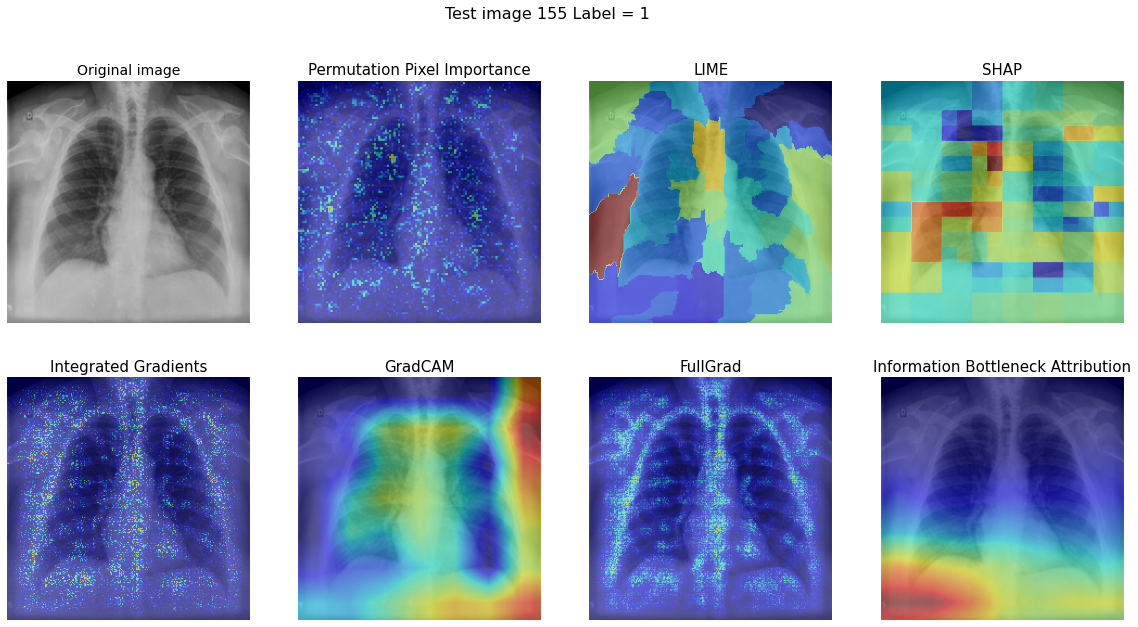

In [ ]:
i = 155
show_explanations(i)

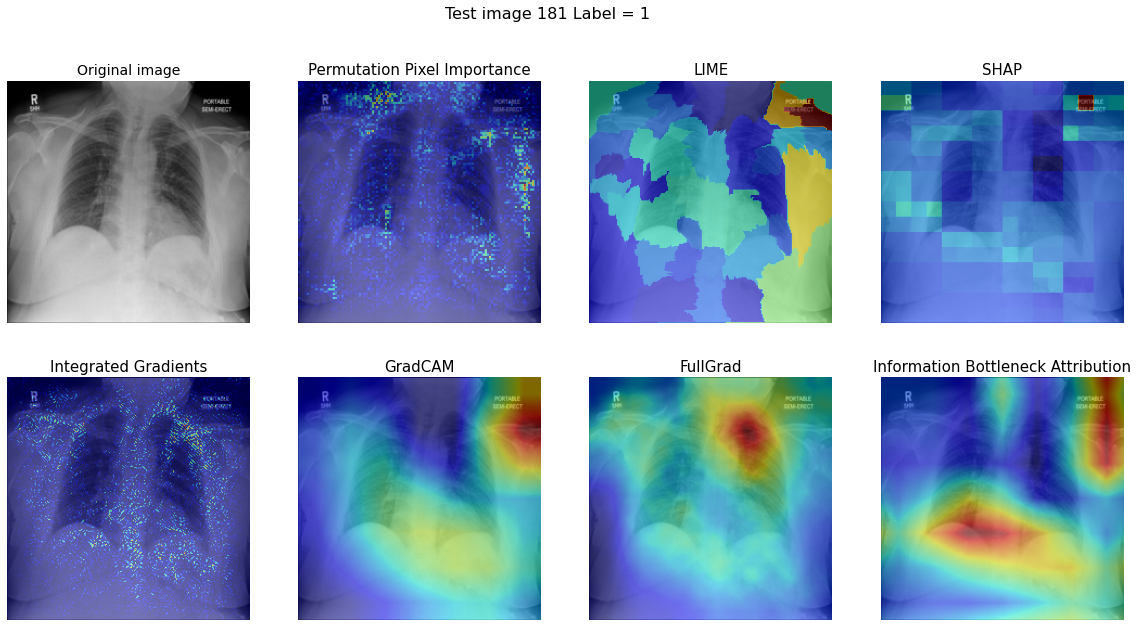

<Figure size 432x288 with 0 Axes>

In [ ]:
total_diffs = np.array(list(explanations_pair_diffs.values())).sum(axis=0)
i = total_diffs.argsort()[7]
show_explanations(i, save_to='gdrive/MyDrive/Diploma/imgs/explanations_' + str(i) + '.png')

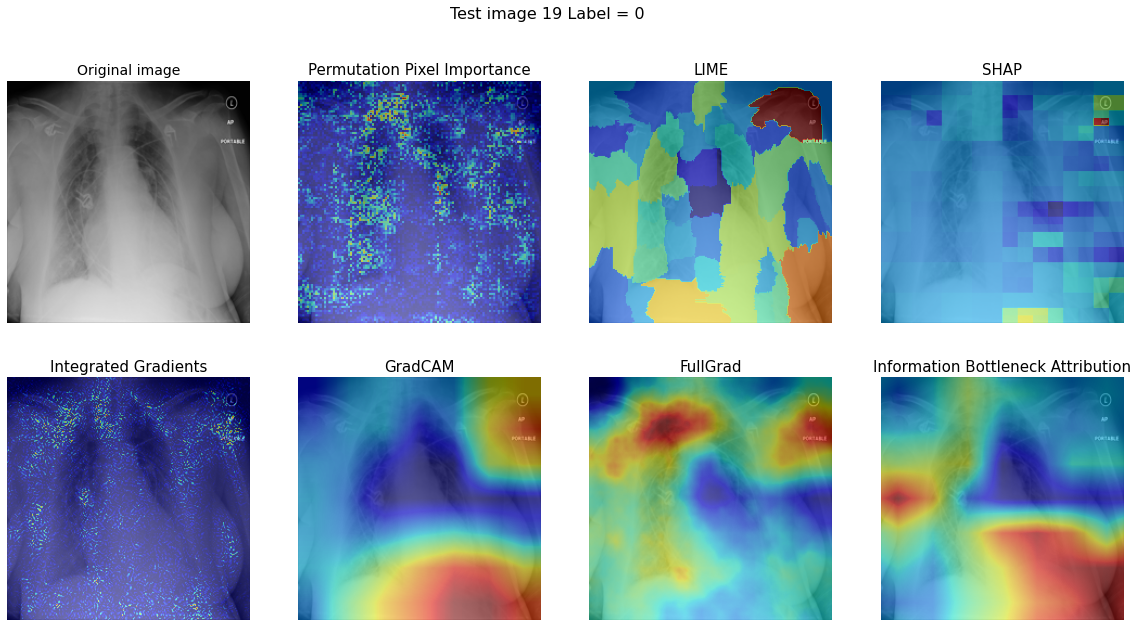

<Figure size 432x288 with 0 Axes>

In [ ]:
i = 19
show_explanations(i, save_to='gdrive/MyDrive/Diploma/imgs/explanations_' + str(i) + '.png')

In [ ]:
np.linalg.norm(img1-img2)

12903.48790056394